In [1]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
d2l.use_svg_display()

In [2]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root='../data',train=True,transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root='../data',train=False,transform=trans,download=True)

In [3]:
len(mnist_train),len(mnist_test)

(60000, 10000)

In [4]:
mnist_train[0][0].shape,mnist_train[0][1]

(torch.Size([1, 28, 28]), 9)

In [5]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle boot']
    return [text_labels[int(i)] for i in labels]

In [6]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

array([<AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'t-shirt'}>], dtype=object)

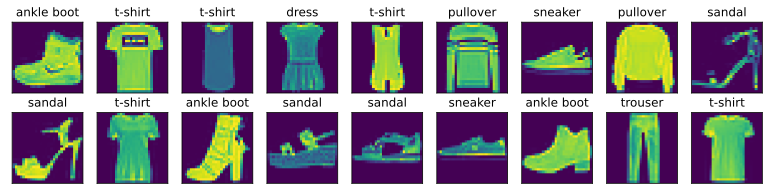

In [7]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18,28,28),2,9,titles=get_fashion_mnist_labels(y))

In [8]:
batch_size = 256
def get_dataloader_workers():
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())

In [9]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec' 

'2.89 sec'

In [10]:
def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
    root = '../data',train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
    root = '../data',train=False, transform=trans,download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers())),(data.DataLoader(mnist_test, batch_size, shuffle=True,num_workers=get_dataloader_workers()))

In [11]:
train_iter, test_iter = load_data_fashion_mnist(32,resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


## Softmax from scratch

In [12]:
import torch
from IPython import display
from d2l import torch as d2l

In [13]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [14]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0,0.01,size=(num_inputs, num_outputs),requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [15]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])),W)+b)

In [16]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

In [17]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)),y])

In [18]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: # if y_hat is multi-dimensional
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [19]:
def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X),y),y.numel())
    return metric[0] / metric[1]

In [20]:
class Accumulator:
    def __init__(self,n):
        self.data = [0.0] * n
        
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self,idx):
        return self.data[idx]

In [21]:
evaluate_accuracy(net, test_iter)

0.0235

In [22]:
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()),accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [27]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        print(f'epoch-{epoch+1:>2d}-{train_metrics+(test_acc,)}')
    train_loss, train_acc = train_metrics

In [28]:
lr = 0.1
def sgd(batch_size):
    with torch.no_grad():
        for param in [W,b]:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [29]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, sgd)

epoch- 1-(0.7853433951059977, 0.74745, 0.7912)
epoch- 2-(0.5706984317143758, 0.8133333333333334, 0.8116)
epoch- 3-(0.5238941738128662, 0.82615, 0.8108)
epoch- 4-(0.5006124618530273, 0.8319833333333333, 0.8212)
epoch- 5-(0.4843142600377401, 0.8365833333333333, 0.8267)
epoch- 6-(0.4742948283513387, 0.84025, 0.8288)
epoch- 7-(0.4644268880208333, 0.8435833333333334, 0.8274)
epoch- 8-(0.4575510040918986, 0.84485, 0.8232)
epoch- 9-(0.4525234074910482, 0.8471666666666666, 0.8264)
epoch-10-(0.4473192477544149, 0.84955, 0.8339)


In [34]:
def predict_ch3(net, test_iter, n=18):
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true+'\n'+pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n,28,28)),1,n,titles=titles[0:n])

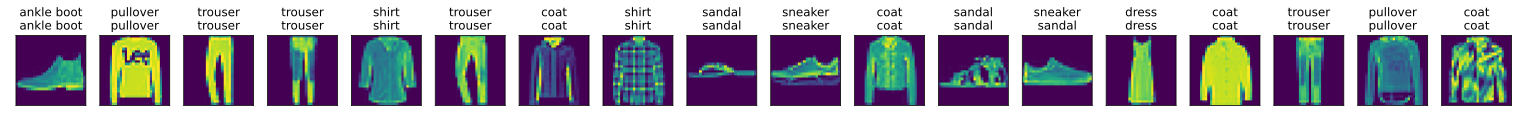

In [35]:
predict_ch3(net, test_iter, 18)